# Normalization stats per timestamp 
- Here we calculate some raster's stats. This is really useful to check that all patchlets have valid data. In the future, this stats will be use to normalize the used data.


In [1]:
import os
import shutil

print(os.getcwd())

/data/lscalambrin/proyecto_integrador/segmentation


In [2]:
from functools import partial
from concurrent.futures import ProcessPoolExecutor

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from tqdm.auto import tqdm

from fd.compute_normalization import (ComputeNormalizationConfig, 
                                      stats_per_npz_ts, 
                                      prepare_filesystem,
                                      concat_npz_results,
                                      create_per_band_norm_dataframe)
from fd.utils import multiprocess

## Config

In [3]:
save_patchlet_npz = '/data/lscalambrin/proyecto_integrador/segmentation/pergamino/patchlets_npz'
df_path = '/data/lscalambrin/proyecto_integrador/segmentation/pergamino/patchlet-info.csv'

config = ComputeNormalizationConfig(
    bucket_name='bucket-name',
    aws_access_key_id='',
    aws_secret_access_key='',
    aws_region='eu-central-1',
    npz_files_folder=save_patchlet_npz,
    metadata_file=df_path)

In [4]:
npz_files = os.listdir(config.npz_files_folder)

In [5]:
partial_fn = partial(stats_per_npz_ts, config=config)
results = multiprocess(partial_fn, npz_files, max_workers=24)

  0%|          | 0/114 [00:00<?, ?it/s]

In [6]:
# choose here which stats you are interested in from
# ['mean', 'std', 'median', 'minimum', 'maximum', 'perc_1', 'perc_5', 'perc_95', 'perc_99']
stats_keys = ['mean', 'std', 'median', 'perc_99']
identifier_keys = ['timestamp', 'patchlet'] 

concatenated_stats = {}

for key in stats_keys+identifier_keys: 
    concatenated_stats[key] = concat_npz_results(key, results)

In [7]:
df = create_per_band_norm_dataframe(concatenated_stats, stats_keys, identifier_keys)

In [8]:
df[df.mean_b0==0]

,mean_b0,mean_b1,mean_b2,mean_b3,std_b0,std_b1,std_b2,std_b3,median_b0,median_b1,median_b2,median_b3,perc_99_b0,perc_99_b1,perc_99_b2,perc_99_b3,timestamp,patchlet


In [9]:
### Block to delete bad data. If the above dataframe is not empty, this code should be executed and also notebook 05 and 06(again),
### so previously we need to remove npz directory, which is "/data/lscalambrin/proyecto_integrador/segmentation/pergamino/patchlets_npz/" 
### for pergamino region
# tmp = df[df.mean_b0==0]
# tmp_list = tmp.patchlet.tolist()
# mylist = list( dict.fromkeys(tmp_list) )
# for dir_patchlet in mylist:
#     if os.path.exists(dir_patchlet):
#         shutil.rmtree(dir_patchlet)
#         print('in')

## Analysis

In [10]:
# convert to datetime
timestamps = df['timestamp'].apply(lambda d: d.tz_localize(None))
df['timestamp']=timestamps.astype(np.datetime64)

# add "month" period
df['month']=df.timestamp.dt.to_period("M")

In [13]:
def plot_distributions(dataframe, stat, stat_title=None):
    colors = ['b','g','r','y']
    bands = list(range(4))
    
    if not stat_title:
        stat_title = stat

    log=True
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(18,13))
    for band in bands:
        dataframe.hist(f'{stat}_b{band}', ax=ax[0], range=(0,10000),
                       bins=100, log=log, color=colors[band], 
                       alpha=0.3, label=f'b{band}')
    ax[0].legend()
    ax[0].grid(axis='x')
    ax[0].set_title(f'Histograms of {stat_title}');

    log=False
    for band in bands:
        dataframe.hist(f'{stat}_b{band}', cumulative=True,  range=(0,10000),
                       density=True, ax=ax[1], bins=100, log=log, 
                       color=colors[band], alpha=0.3, label=f'b{band}')
    ax[1].legend()
    ax[1].grid(axis='x')
    ax[1].set_title(f'Cumulative distributions of {stat_title}');

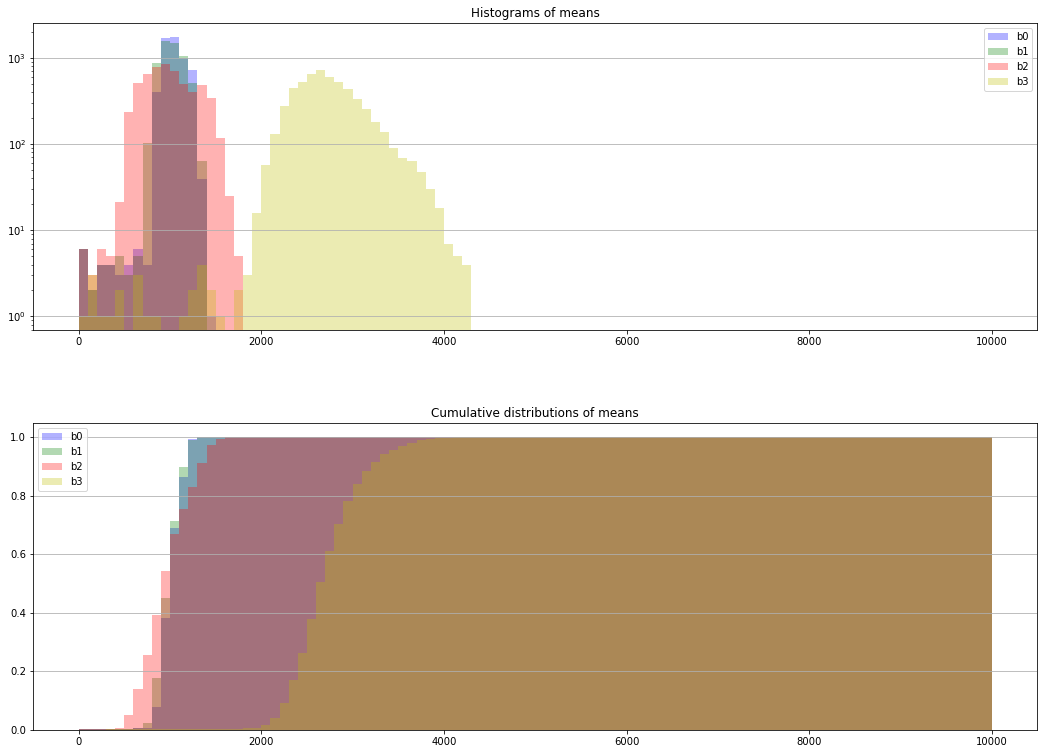

In [14]:
plot_distributions(df, 'mean','means')

### How do distributions change through time?

In [16]:
aggs = {}
stat_cols = []
stats = ['perc_99', 'mean', 'median', 'std']
bands = list(range(4))
for stat in stats:
    for band in bands:
        aggs[f'{stat}_b{band}'] = [np.std, np.mean];
        stat_cols.append(f'{stat}_b{band}')

In [17]:
monthly = pd.DataFrame(df.groupby('month', as_index=False)[stat_cols].agg(aggs))
monthly.columns = ['_'.join(col).strip() for col in monthly.columns.values]
monthly.rename(columns={'month_':'month'}, inplace=True)

In [18]:
monthly

,month,perc_99_b0_std,perc_99_b0_mean,perc_99_b1_std,perc_99_b1_mean,perc_99_b2_std,perc_99_b2_mean,perc_99_b3_std,perc_99_b3_mean,mean_b0_std,...,median_b3_std,median_b3_mean,std_b0_std,std_b0_mean,std_b1_std,std_b1_mean,std_b2_std,std_b2_mean,std_b3_std,std_b3_mean
0,2017-09,74.894886,1359.660643,111.888942,1362.768223,189.092044,1689.874900,433.811518,4631.872590,46.247688,...,303.971575,2362.062249,27.056494,151.959767,29.272257,151.973556,66.046252,353.938057,158.226421,798.169624
1,2017-10,82.567255,1376.967821,112.468237,1373.530171,186.851432,1685.996486,446.601423,4378.851556,50.846910,...,287.977155,2317.145582,29.651316,164.198739,33.544649,167.666855,68.091272,358.093192,154.286776,718.156053
2,2017-11,83.740627,1482.320000,132.668114,1537.401291,251.972048,2015.665352,374.169478,3534.983075,90.630445,...,233.632235,2351.761737,48.001644,129.689098,50.951725,145.226534,74.206048,301.447610,125.815210,382.269817
3,2017-12,132.485238,1486.117144,203.513469,1608.944252,353.038898,2081.022339,387.563234,3840.835668,73.470644,...,198.691508,2634.069026,35.058276,170.641841,54.755272,207.365838,98.763875,421.924147,99.070998,455.153152
4,2018-01,100.213248,1267.696260,131.196870,1286.506350,225.773416,1490.694202,446.782608,4581.191918,51.912184,...,320.097359,2924.895331,29.519295,123.550397,32.489512,145.584074,68.496495,290.605153,158.229972,651.274390
5,2018-02,142.270503,1199.258276,158.747906,1213.671379,249.301490,1395.047241,630.855789,5068.132414,217.700196,...,1086.896286,3037.575862,115.821340,165.022698,102.569383,189.296227,74.530577,291.789479,321.341126,952.212094
6,2018-03,133.519640,1287.864589,178.756313,1326.221688,377.652187,1616.982184,461.480852,4144.568784,73.557116,...,409.663412,2927.781590,31.167437,105.394009,37.288626,135.080186,84.863247,285.048127,165.757992,572.453195


In [28]:
def monthly_stats(monthly_df, stat, stat_title=None):
    fig, ax = plt.subplots(figsize=(12,9))
    cols = ['b','g','r','y']
    bands = ['Azul', 'Verde', 'Roja', 'NIR']
    if not stat_title:
        stat_title = stat
        
    for band in range(4):
        x_vals = np.array([m.month if m.month>=9 else m.month+12 for m in monthly_df['month']])

        ax.plot(x_vals, monthly_df[f'{stat}_b{band}_mean'].values, 
                color=cols[band], label=f'Banda {bands[band]}')
        
        ax.scatter(x_vals, monthly_df[f'{stat}_b{band}_mean'].values, 
                color=cols[band])
        ax.fill_between(x_vals, 
                        monthly_df[f'{stat}_b{band}_mean'].values - 
                        monthly_df[f'{stat}_b{band}_std'].values, 
                        monthly_df[f'{stat}_b{band}_mean'].values + 
                        monthly_df[f'{stat}_b{band}_std'].values, color=cols[band], 
                        alpha=0.2)
        str_month_list = ['a','Sep','Oct','Nov','Dic','En', 'Feb','Mar']
#         ax.set_xticks(range(9,15) 
        ax.set_xticklabels(str_month_list)
    ax.tick_params(direction='out', length=6, width=2, grid_alpha=0.5,labelsize = 15)
    ax.legend(fontsize = 15)
    ax.grid()
    ax.set_title(f'{stat_title} through months')
#     ax.set_title('Valor medio', fontsize = 19)
    ax.set_title('Desviación estándar', fontsize = 19)

<ipython-input-26-4c56317294ae>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(str_month_list)
<ipython-input-26-4c56317294ae>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(str_month_list)
<ipython-input-26-4c56317294ae>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(str_month_list)
<ipython-input-26-4c56317294ae>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(str_month_list)


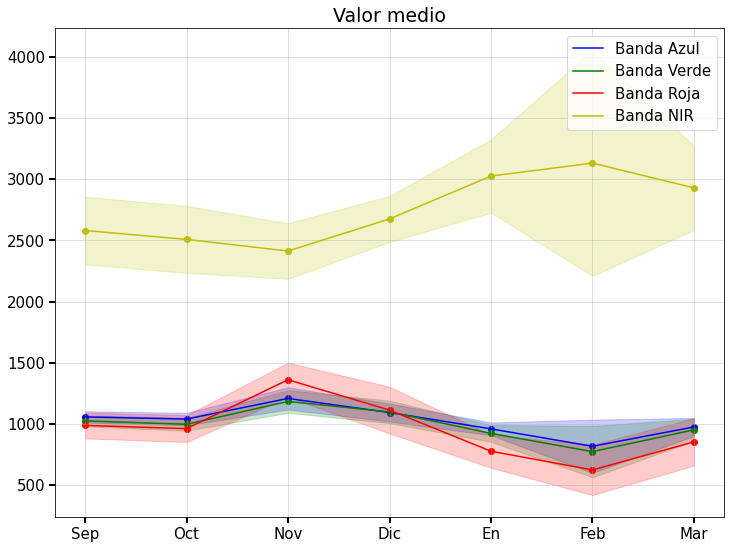

In [27]:
monthly_stats(monthly, 'mean', 'means')

<ipython-input-28-064b5517d441>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(str_month_list)
<ipython-input-28-064b5517d441>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(str_month_list)
<ipython-input-28-064b5517d441>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(str_month_list)
<ipython-input-28-064b5517d441>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(str_month_list)


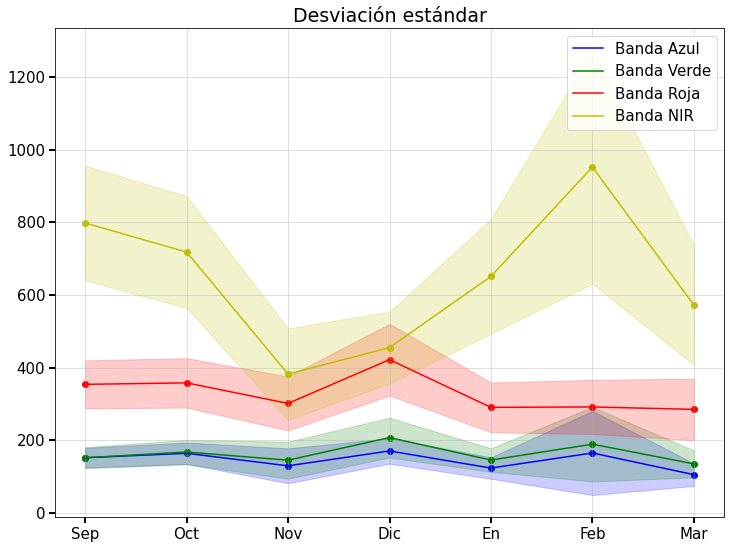

In [29]:
monthly_stats(monthly, 'std', 'standard deviations')

## Normalization factors per month per band

We calculate normalization factors for two different normalizations

In [35]:
norm_cols = [norm.format(band) 
             for norm in ['perc_99_b{0}_mean', 
                          'mean_b{0}_mean', 
                          'median_b{0}_mean', 
                          'std_b{0}_mean'] for band in range(4)]

def norms(month):
    return monthly.loc[monthly.month==month][norm_cols].values[0]

In [36]:
df['norm_perc99_b0'], df['norm_perc99_b1'], df['norm_perc99_b2'], df['norm_perc99_b3'], \
df['norm_meanstd_mean_b0'], df['norm_meanstd_mean_b1'], df['norm_meanstd_mean_b2'], df['norm_meanstd_mean_b3'], \
df['norm_meanstd_median_b0'], df['norm_meanstd_median_b1'], df['norm_meanstd_median_b2'], df['norm_meanstd_median_b3'], \
df['norm_meanstd_std_b0'], df['norm_meanstd_std_b1'], df['norm_meanstd_std_b2'], df['norm_meanstd_std_b3'] = zip(*map(norms, df.month))

<AxesSubplot:>

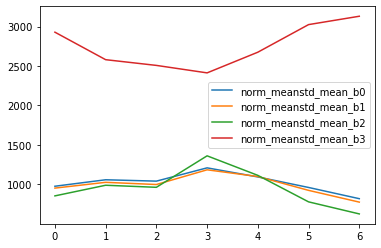

In [39]:
# another check; should be similar to `monthly_stats(monthly, 'mean','means')`
df[['month','norm_meanstd_mean_b0','norm_meanstd_mean_b1','norm_meanstd_mean_b2','norm_meanstd_mean_b3']].drop_duplicates().reset_index(drop=True).plot()

## Add this info to patchlet info

In [ ]:
df.columns

In [41]:
len(df)

5670

In [42]:
with open(config.metadata_file, 'rb') as fcsv:
    df_info = pd.read_csv(fcsv)

In [43]:
df_info['timestamp'] = pd.to_datetime(df_info.timestamp)

In [44]:
timestamps = df_info['timestamp'].apply(lambda d: d.tz_localize(None))
df_info['timestamp'] = timestamps.astype(np.datetime64)

In [ ]:
df_info.head()

In [ ]:
new_df = df_info.merge(df, how='inner', on=['patchlet', 'timestamp'])

In [ ]:
len(new_df)

In [ ]:
new_df.head()

In [49]:
with open(config.metadata_file, 'w') as fcsv:
    new_df.to_csv(fcsv, index=False)